In [213]:
import numpy as np
import cv2
import random

def generate_dust_mask(
    image_shape=(512, 512),
    num_blobs=20,
    num_scratches=4,
    num_hairs=15,
    max_blob_size = 2,
    max_scratch_length=300,
    max_hair_length=100,
    squiggliness=0.9,  # 0 = straight line, 1 = max squiggle
    blur_kernel=(3, 3)
):
    """
    Generates a binary dust mask with ellipses, scratches, and hairs.
    squiggliness (0 to 1): controls how much hairs/fibers wiggle.
    """
    h, w = image_shape
    mask = np.zeros((h, w), dtype=np.uint8)

    def rand_count(base):
        return random.randint(int(base * 0.5), int(base * 1.5))

    num_blobs = rand_count(num_blobs)
    num_scratches = rand_count(num_scratches)
    num_hairs = rand_count(num_hairs)

    # Dust blobs (ellipses)
    for _ in range(num_blobs):
        center = (random.randint(0, w), random.randint(0, h))
        axes = (
            random.randint(1, max_blob_size),
            random.randint(1, max(1, max_blob_size // 2))
        )
        angle = random.randint(0, 180)
        cv2.ellipse(mask, center, axes, angle, 0, 360, 255, -1)

    # Scratches (lines with per-object random length)
    for _ in range(num_scratches):
        x1, y1 = random.randint(0, w), random.randint(0, h)
        angle = random.uniform(0, 2 * np.pi)
        length = random.randint(20, max_scratch_length)
        x2 = int(x1 + length * np.cos(angle))
        y2 = int(y1 + length * np.sin(angle))
        thickness = random.randint(1, 1)
        cv2.line(mask, (x1, y1), (x2, y2), 255, thickness)

    # Hairs or fibers (squiggly lines)
    for _ in range(num_hairs):
        points = []
        x, y = random.randint(0, w), random.randint(0, h)
        hair_length = random.randint(30, max_hair_length)
        num_segments = max(3, hair_length // 10)

        # Base direction to make line mostly straight
        angle = random.uniform(0, 2 * np.pi)
        dx_base = np.cos(angle)
        dy_base = np.sin(angle)

        for _ in range(num_segments):
            # Apply squiggliness as jitter around base direction
            dx = dx_base * 10 + squiggliness * random.uniform(-10, 10)
            dy = dy_base * 10 + squiggliness * random.uniform(-10, 10)
            x = int(np.clip(x + dx, 0, w - 1))
            y = int(np.clip(y + dy, 0, h - 1))
            points.append((x, y))

        for i in range(len(points) - 1):
            cv2.line(mask, points[i], points[i + 1], 255, 1)

    # Optional blur and threshold
    final_mask = mask.copy()
    final_mask = cv2.GaussianBlur(mask, blur_kernel, 0)
    return mask  # anti-aliased grayscale mask

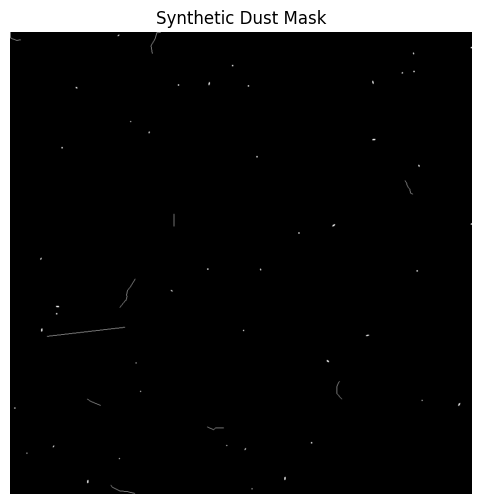

In [203]:
import matplotlib.pyplot as plt

mask = generate_dust_mask(image_shape=(1024, 1024))

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray', interpolation='bilinear')
plt.title("Synthetic Dust Mask")
plt.axis('off')
plt.show()

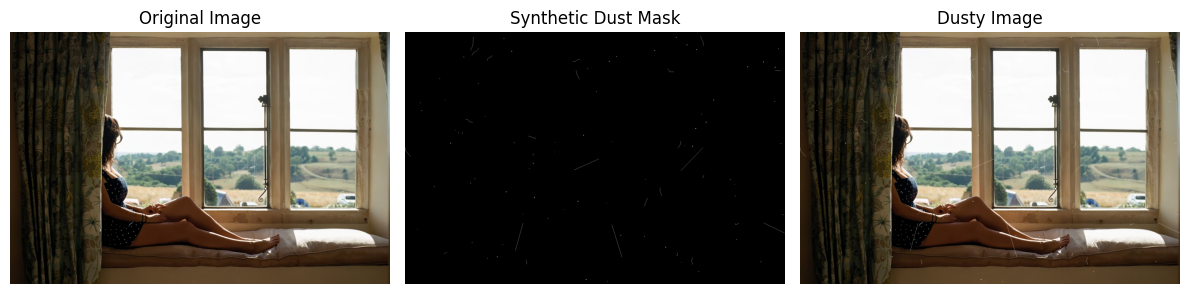

In [204]:
def apply_dust_to_color_image(image_bgr, mask, intensity=255):
    """
    Applies anti-aliased dust mask to brightness channel.
    mask: grayscale mask with values in [0, 255]
    """
    # Convert to YCrCb
    image_ycrcb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(image_ycrcb)

    # Normalize mask to [0.0, 1.0]
    mask_float = mask.astype(np.float32) / 255.0

    # Add scaled intensity based on soft edges
    y = y.astype(np.float32)
    y += mask_float * intensity
    y = np.clip(y, 0, 255).astype(np.uint8)

    # Reconstruct and convert back to BGR
    image_dusty_ycrcb = cv2.merge([y, cr, cb])
    image_dusty_bgr = cv2.cvtColor(image_dusty_ycrcb, cv2.COLOR_YCrCb2BGR)
    return image_dusty_bgr

# ---- Load Image ----
img_path = "film-dataset/1216x806x2 (8)-topaz-denoise.jpeg"
image = cv2.imread(img_path)  # BGR
if image is None:
    raise FileNotFoundError(f"Could not read {img_path}")
h, w = image.shape[:2]

# ---- Generate Mask & Apply ----
mask = generate_dust_mask(image_shape=(h, w), squiggliness=0.7)
dusty_image = apply_dust_to_color_image(image, mask, intensity=255)

# ---- Visualize ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Synthetic Dust Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(dusty_image, cv2.COLOR_BGR2RGB))
plt.title("Dusty Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [205]:

plt.imsave("dusty_image.png", cv2.cvtColor(dusty_image, cv2.COLOR_BGR2RGB))

In [172]:
!pip install torch torchvision albumentations matplotlib scikit-image opencv-python tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [albumentations]m [albucore]thon-headless]


In [214]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
from torchvision import transforms

class DustDataset(Dataset):
    def __init__(self, root_dir, image_size=(512, 512), transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        clean_img = cv2.imread(path)
        clean_img = cv2.resize(clean_img, self.image_size)

        # generate synthetic dust mask
        mask = generate_dust_mask(image_shape=self.image_size, squiggliness=0.7)

        # apply dust to the clean image using the mask
        dusty_img = apply_dust_to_color_image_aa(clean_img, mask, intensity=200)

        # Normalize and prepare inputs
        image = dusty_img.astype(np.float32) / 255.0
        mask = (mask.astype(np.float32) / 255.0)[..., np.newaxis]  # HWC → HW1

        # Apply augmentation (optional)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # CHW
        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))

        return image, mask

In [207]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

In [208]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU()
            )

        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)           # 512
        e2 = self.enc2(self.pool(e1))  # 256
        e3 = self.enc3(self.pool(e2))  # 128
        e4 = self.enc4(self.pool(e3))  # 64

        m = self.middle(self.pool(e4))  # 32

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))  # 64
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1)) # 128
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1)) # 256
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1)) # 512

        return torch.sigmoid(self.final(d1))  # 1x512x512

In [218]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
dataset = DustDataset("film-dataset", transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")

100%|██████████| 79/79 [07:31<00:00,  5.72s/it]


Epoch 1: Loss = 0.4989


100%|██████████| 79/79 [05:25<00:00,  4.12s/it]


Epoch 2: Loss = 0.3901


100%|██████████| 79/79 [09:55<00:00,  7.54s/it]


Epoch 3: Loss = 0.0328


100%|██████████| 79/79 [15:56<00:00, 12.10s/it] 


Epoch 4: Loss = 0.0246


100%|██████████| 79/79 [06:49<00:00,  5.18s/it]


Epoch 5: Loss = 0.0163


100%|██████████| 79/79 [06:14<00:00,  4.74s/it]


Epoch 6: Loss = 0.0130


100%|██████████| 79/79 [04:57<00:00,  3.77s/it]


Epoch 7: Loss = 0.0117


100%|██████████| 79/79 [07:31<00:00,  5.71s/it]


Epoch 8: Loss = 0.0097


100%|██████████| 79/79 [08:15<00:00,  6.27s/it]


Epoch 9: Loss = 0.0083


100%|██████████| 79/79 [05:00<00:00,  3.81s/it]

Epoch 10: Loss = 0.0072


In [ ]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")

 18%|█▊        | 14/79 [01:41<03:53,  3.60s/it]

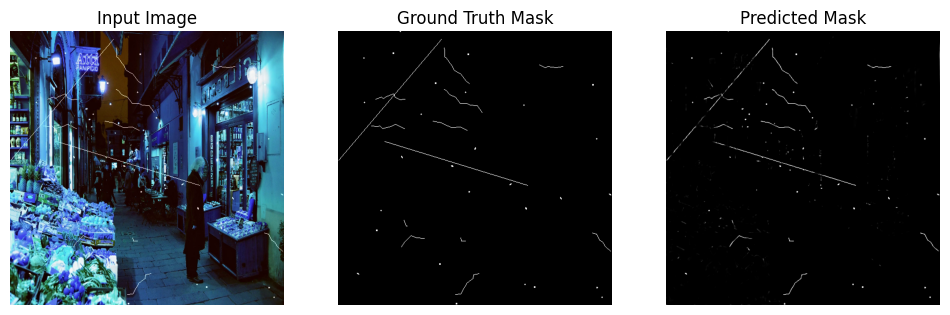

In [222]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(loader))
    preds = model(images.to(device)).cpu()

# Plot side-by-side for sanity check

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.transpose(masks[0].numpy(), (1, 2, 0)), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.transpose(preds[0].numpy(), (1, 2, 0)), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [223]:
plt.imsave("predicted_mask.png", np.transpose(preds[0].numpy(), (1, 2, 0)).squeeze(), cmap='gray')

In [224]:
plt.imsave("input_image.png", np.transpose(images[0].numpy(), (1, 2, 0)))